In [102]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [103]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
y=train['OUTCOME']
ID = test['ID']

In [104]:
train

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,19557,65+,female,0-9y,high school,upper class,0.672255,1.0,before 2015,0.0,0.0,31885,9000.0,2,0,0,0.0,SUV
104996,222459,40-64,female,0-9y,none,working class,0.514193,1.0,after 2015,1.0,0.0,32277,10000.0,0,0,0,1.0,Sedan
104997,83089,16-25,male,10-19y,none,upper class,0.461942,1.0,after 2015,1.0,0.0,34800,11000.0,0,0,0,1.0,Sedan
104998,984879,40-64,female,20-29y,high school,working class,0.483571,1.0,before 2015,0.0,0.0,10238,10000.0,0,0,0,0.0,HatchBack


In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105000 non-null  int64  
 1   AGE                  105000 non-null  object 
 2   GENDER               105000 non-null  object 
 3   DRIVING_EXPERIENCE   105000 non-null  object 
 4   EDUCATION            105000 non-null  object 
 5   INCOME               105000 non-null  object 
 6   CREDIT_SCORE         105000 non-null  float64
 7   VEHICLE_OWNERSHIP    105000 non-null  float64
 8   VEHICLE_YEAR         105000 non-null  object 
 9   MARRIED              105000 non-null  float64
 10  CHILDREN             105000 non-null  float64
 11  POSTAL_CODE          105000 non-null  int64  
 12  ANNUAL_MILEAGE       105000 non-null  float64
 13  SPEEDING_VIOLATIONS  105000 non-null  int64  
 14  DUIS                 105000 non-null  int64  
 15  PAST_ACCIDENTS   

In [107]:
cats = ['AGE','GENDER','DRIVING_EXPERIENCE','EDUCATION','INCOME','VEHICLE_YEAR','TYPE_OF_VEHICLE']

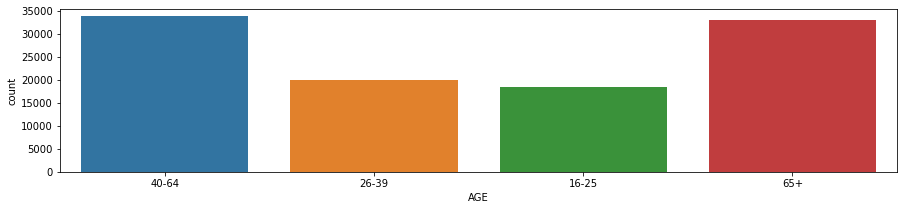

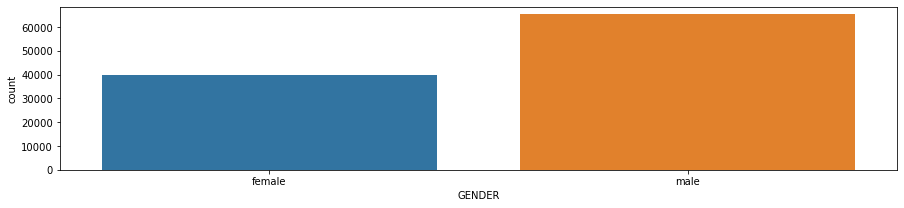

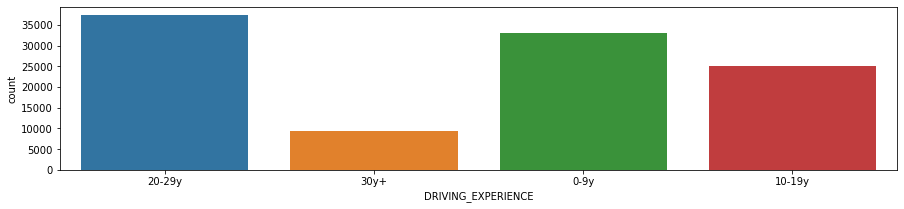

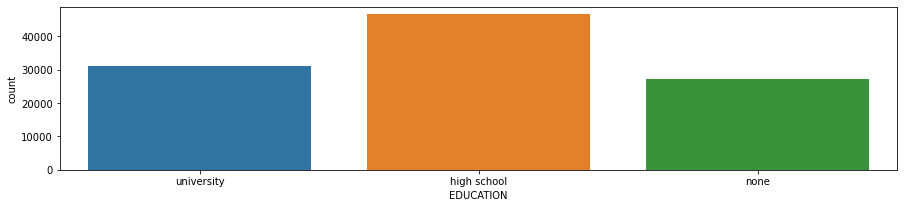

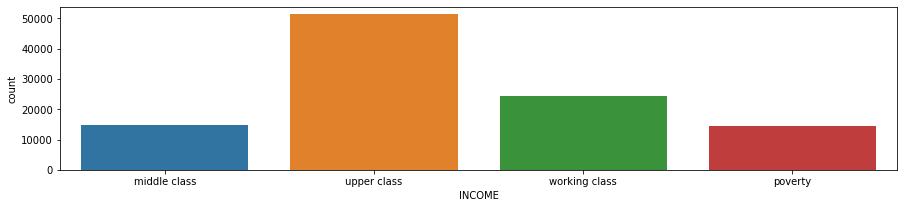

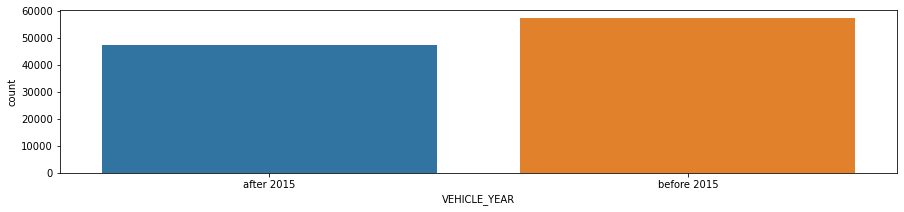

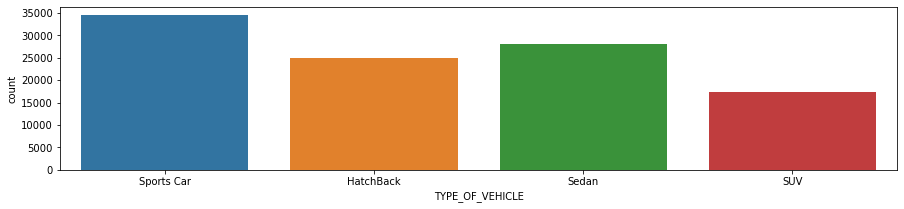

In [108]:
for i in cats:
    plt.figure(figsize=(15,3))
    sns.countplot(train[i])


In [109]:
data=pd.concat((train,test)).reset_index(drop=True).copy()
data=data.drop(columns=['ID','OUTCOME'],axis=1)

In [110]:
data

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,TYPE_OF_VEHICLE
0,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,Sports Car
1,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,HatchBack
2,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,Sedan
3,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,Sedan
4,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,Sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,65+,female,20-29y,high school,poverty,0.472022,1.0,before 2015,1.0,0.0,10238,10000.0,0,0,1,Sports Car
149996,40-64,male,20-29y,university,working class,0.757312,0.0,before 2015,1.0,0.0,10238,12000.0,0,0,0,Sports Car
149997,40-64,male,10-19y,none,poverty,0.566764,0.0,after 2015,0.0,0.0,10238,13000.0,0,0,0,Sedan
149998,65+,male,30y+,high school,upper class,0.741850,1.0,before 2015,1.0,0.0,92101,13000.0,1,0,0,Sports Car


In [111]:
cat_features = [c for c, dt in data.dtypes.items() if dt=='object']
data[cat_features] = data[cat_features].astype("category")

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   AGE                  150000 non-null  category
 1   GENDER               150000 non-null  category
 2   DRIVING_EXPERIENCE   150000 non-null  category
 3   EDUCATION            150000 non-null  category
 4   INCOME               150000 non-null  category
 5   CREDIT_SCORE         150000 non-null  float64 
 6   VEHICLE_OWNERSHIP    150000 non-null  float64 
 7   VEHICLE_YEAR         150000 non-null  category
 8   MARRIED              150000 non-null  float64 
 9   CHILDREN             150000 non-null  float64 
 10  POSTAL_CODE          150000 non-null  int64   
 11  ANNUAL_MILEAGE       150000 non-null  float64 
 12  SPEEDING_VIOLATIONS  150000 non-null  int64   
 13  DUIS                 150000 non-null  int64   
 14  PAST_ACCIDENTS       150000 non-null  int64   
 15  

<AxesSubplot:>

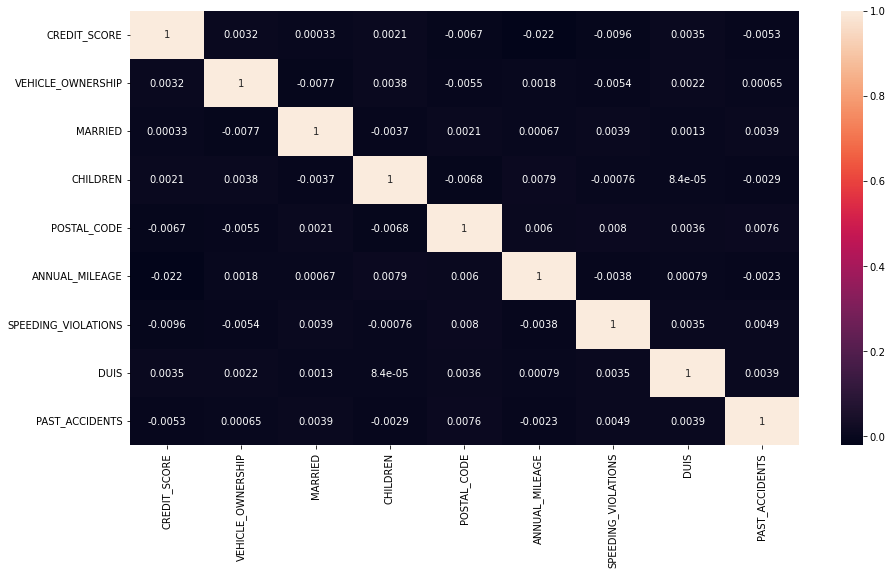

In [113]:
plt.figure(figsize = (15,8))
sns.heatmap(data.corr(),annot=True)


In [50]:
train

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,19557,65+,female,0-9y,high school,upper class,0.672255,1.0,before 2015,0.0,0.0,31885,9000.0,2,0,0,0.0,SUV
104996,222459,40-64,female,0-9y,none,working class,0.514193,1.0,after 2015,1.0,0.0,32277,10000.0,0,0,0,1.0,Sedan
104997,83089,16-25,male,10-19y,none,upper class,0.461942,1.0,after 2015,1.0,0.0,34800,11000.0,0,0,0,1.0,Sedan
104998,984879,40-64,female,20-29y,high school,working class,0.483571,1.0,before 2015,0.0,0.0,10238,10000.0,0,0,0,0.0,HatchBack


## Trying L1 as a Feature Selector

In [78]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(train.select_dtypes(include=numerics).columns)
data = train[numerical_vars]
data.shape

(105000, 11)

In [79]:
data

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,816393,0.638050,0.0,0.0,0.0,37379,11000.0,0,0,0,0.0
1,251762,0.475741,1.0,1.0,0.0,10238,9000.0,0,0,0,1.0
2,481952,0.839817,1.0,1.0,1.0,10238,12000.0,0,0,0,1.0
3,3506,0.682527,1.0,0.0,1.0,92099,6000.0,1,0,0,1.0
4,498013,0.572184,1.0,1.0,1.0,32122,15000.0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
104995,19557,0.672255,1.0,0.0,0.0,31885,9000.0,2,0,0,0.0
104996,222459,0.514193,1.0,1.0,0.0,32277,10000.0,0,0,0,1.0
104997,83089,0.461942,1.0,1.0,0.0,34800,11000.0,0,0,0,1.0
104998,984879,0.483571,1.0,0.0,0.0,10238,10000.0,0,0,0,0.0


In [81]:
data.drop(['OUTCOME'],axis=1,inplace=True)
data.columns

Index(['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')

In [82]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [83]:
data = pd.DataFrame(data)
data.columns=['ID', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS']

In [84]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1'))

In [85]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

sel_.fit(data, y)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [86]:
sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [87]:
selected_feat = data.columns[(sel_.get_support())]
print('total features: {}'.format((data.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 10
selected features: 10
features with coefficients shrank to zero: 0


In [88]:
np.sum(sel_.estimator_.coef_ == 0)

0

In [89]:
removed_feats = data.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index([], dtype='object')

## Doesnt helpful lasso !!!

In [92]:
train=data[:len(train)]
test=data[len(train):]

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
train_X, val_X, train_y, val_y = train_test_split(train, y, test_size=0.33, random_state=42)

In [95]:
lgb_clf = lgb.LGBMClassifier(learning_rate=0.01, n_estimators=1000, random_state=42,objective='binary',
       metric='binary_logloss',)


In [98]:
lgb_clf.fit(train_X, train_y,  eval_set=(val_X, val_y), early_stopping_rounds=500)

pred=lgb_clf.predict_proba(test,num_iteration=lgb_clf.best_iteration_)[:,1]


[1]	valid_0's binary_logloss: 0.68154
[2]	valid_0's binary_logloss: 0.681534
[3]	valid_0's binary_logloss: 0.68153
[4]	valid_0's binary_logloss: 0.681526
[5]	valid_0's binary_logloss: 0.681526
[6]	valid_0's binary_logloss: 0.681521
[7]	valid_0's binary_logloss: 0.681522
[8]	valid_0's binary_logloss: 0.681519
[9]	valid_0's binary_logloss: 0.681518
[10]	valid_0's binary_logloss: 0.681515
[11]	valid_0's binary_logloss: 0.681516
[12]	valid_0's binary_logloss: 0.681515
[13]	valid_0's binary_logloss: 0.681516
[14]	valid_0's binary_logloss: 0.681517
[15]	valid_0's binary_logloss: 0.681517
[16]	valid_0's binary_logloss: 0.681518
[17]	valid_0's binary_logloss: 0.681518
[18]	valid_0's binary_logloss: 0.681518
[19]	valid_0's binary_logloss: 0.681522
[20]	valid_0's binary_logloss: 0.681527
[21]	valid_0's binary_logloss: 0.681531
[22]	valid_0's binary_logloss: 0.681532
[23]	valid_0's binary_logloss: 0.681532
[24]	valid_0's binary_logloss: 0.681536
[25]	valid_0's binary_logloss: 0.681537
[26]	valid_

[206]	valid_0's binary_logloss: 0.68194
[207]	valid_0's binary_logloss: 0.681946
[208]	valid_0's binary_logloss: 0.681942
[209]	valid_0's binary_logloss: 0.681943
[210]	valid_0's binary_logloss: 0.681946
[211]	valid_0's binary_logloss: 0.681948
[212]	valid_0's binary_logloss: 0.681951
[213]	valid_0's binary_logloss: 0.681951
[214]	valid_0's binary_logloss: 0.681951
[215]	valid_0's binary_logloss: 0.681953
[216]	valid_0's binary_logloss: 0.681955
[217]	valid_0's binary_logloss: 0.681953
[218]	valid_0's binary_logloss: 0.681951
[219]	valid_0's binary_logloss: 0.681956
[220]	valid_0's binary_logloss: 0.681956
[221]	valid_0's binary_logloss: 0.681961
[222]	valid_0's binary_logloss: 0.681962
[223]	valid_0's binary_logloss: 0.681962
[224]	valid_0's binary_logloss: 0.681964
[225]	valid_0's binary_logloss: 0.681967
[226]	valid_0's binary_logloss: 0.681967
[227]	valid_0's binary_logloss: 0.681969
[228]	valid_0's binary_logloss: 0.681969
[229]	valid_0's binary_logloss: 0.681973
[230]	valid_0's b

[423]	valid_0's binary_logloss: 0.682382
[424]	valid_0's binary_logloss: 0.682381
[425]	valid_0's binary_logloss: 0.682387
[426]	valid_0's binary_logloss: 0.682389
[427]	valid_0's binary_logloss: 0.682388
[428]	valid_0's binary_logloss: 0.682391
[429]	valid_0's binary_logloss: 0.682392
[430]	valid_0's binary_logloss: 0.682394
[431]	valid_0's binary_logloss: 0.682395
[432]	valid_0's binary_logloss: 0.682397
[433]	valid_0's binary_logloss: 0.682403
[434]	valid_0's binary_logloss: 0.682405
[435]	valid_0's binary_logloss: 0.682407
[436]	valid_0's binary_logloss: 0.682407
[437]	valid_0's binary_logloss: 0.682411
[438]	valid_0's binary_logloss: 0.682413
[439]	valid_0's binary_logloss: 0.682413
[440]	valid_0's binary_logloss: 0.682414
[441]	valid_0's binary_logloss: 0.682416
[442]	valid_0's binary_logloss: 0.682419
[443]	valid_0's binary_logloss: 0.682422
[444]	valid_0's binary_logloss: 0.682421
[445]	valid_0's binary_logloss: 0.682423
[446]	valid_0's binary_logloss: 0.682421
[447]	valid_0's 

ValueError: Input data must be 2 dimensional and non empty.

In [100]:
pred

NameError: name 'pred' is not defined

In [101]:
submission = pd.DataFrame({"OUTCOME":pred})

NameError: name 'pred' is not defined

In [12]:
submission.to_csv('submission_01.csv', index=False)